# Photo Z with Neural Network

## Fig 9.X

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata

from astroML.datasets import fetch_sdss_specgals
from astroML.utils.decorators import pickle_results

In [2]:
import numpy as np
from matplotlib import pyplot as plt


In [3]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec

In [4]:
N=10
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

In [5]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


In [6]:
#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=18, usetex=True)

# Fetch and prepare the data

In [7]:
# Fetch and prepare the data
data = fetch_sdss_specgals()

# put magnitudes into array

In [8]:
# normalize to zero mean and unit variance for easier training
datanormed = np.zeros((len(data), 6), dtype=np.float32)
for i, band in enumerate(['u', 'g', 'r', 'i', 'z']):
    band = 'modelMag_' + band
    datanormed[:, i] = (data[band] - data[band].mean()) / data[band].std()


# put redshifts into array

In [9]:
# put redshifts into array
datanormed[:, 5] = data['z']


# define structure of neural net

In [10]:
# define structure of neural net
class Net(nn.Module):
    def __init__(self, nhidden):
        super(Net, self).__init__()
        self.fc_h = nn.Linear(5, nhidden)
        self.fc_o = nn.Linear(nhidden, 1)

    def forward(self, x):
        h = F.relu(self.fc_h(x))
        z = self.fc_o(h)
        return z

# split data into 9:1 train:test

In [11]:
# split data into 9:1 train:test
dataset = torchdata.TensorDataset(torch.tensor(datanormed[:, 0:5]),
                                  torch.tensor(datanormed[:, 5]).view(-1, 1))
trainnum = datanormed.shape[0] // 10 * 9
traindata, testdata = torchdata.random_split(dataset, [trainnum, datanormed.shape[0] - trainnum])
traindataloader = torchdata.DataLoader(traindata, batch_size=128, shuffle=True)

In [12]:
@pickle_results('NNphotoz.pkl')
def train_NN():
    model = Net(4)
    criterion = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5, threshold=1e-3)

    min_valid_loss = float('inf')
    badepochs = 0
    for t in range(1000):
        train_loss = 0
        for i, databatch in enumerate(traindataloader, 0):
            photometry, redshifts = databatch
            optimizer.zero_grad()
            z_pred = model(photometry)
            loss = criterion(z_pred, redshifts)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        with torch.no_grad():
            photometry = testdata[:][0]
            redshifts = testdata[:][1]
            z_pred = model(photometry)
            valid_loss = criterion(z_pred, redshifts)
            if t % 10 == 0:
                print('Epoch %3i: train loss %0.3e validation loss %0.3e' % (t, \
                        train_loss / len(traindata), valid_loss / len(testdata)))
            # stop training if validation loss has not fallen in 10 epochs
            if valid_loss > min_valid_loss*(1-1e-3):
                badepochs += 1
            else:
                min_valid_loss = valid_loss
                badepochs = 0
            if badepochs == 10:
                print('Finished training')
                break
        scheduler.step(valid_loss)
    return model

In [13]:
model = train_NN()

@pickle_results: using precomputed results from 'NNphotoz.pkl'


# plot the results

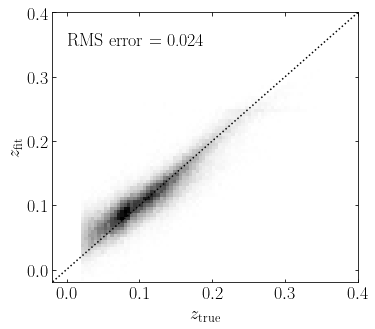

In [14]:
# plot the results
with torch.no_grad():
    photometry = testdata[:][0]
    redshifts = testdata[:][1]
    z_pred = model(photometry)
    fig = plt.figure(figsize=(5, 5))
    fig.subplots_adjust(wspace=0.25,
                        left=0.1, right=0.95,
                        bottom=0.15, top=0.9)

    ax = plt.axes()
    #ax.scatter(redshifts, z_pred, s=1, lw=0, c='k')
    H, zs_bins, zp_bins = np.histogram2d(redshifts.numpy().flatten(), z_pred.numpy().flatten(), 151)
    ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
               extent=[zs_bins[0], zs_bins[-1], zp_bins[0], zp_bins[-1]],
               cmap=plt.cm.binary)
    ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
    rms = np.sqrt(np.mean((z_pred-redshifts).numpy()**2))
    ax.text(0, 0.35, 'RMS error = %0.3f' % np.sqrt(np.mean((z_pred-redshifts).numpy()**2)))
    ax.set_xlim(-0.02, 0.4001)
    ax.set_ylim(-0.02, 0.4001)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.set_xlabel(r'$z_{\rm true}$')
    ax.set_ylabel(r'$z_{\rm fit}$')
    plt.show()
